# Proyecto práctico: árbol de decisión y random forest con scikit-learn

In [1]:
#Importamos las librerias principales
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

Utilizaremos el **Car Evaluation Data Set** de Kaggle: https://www.kaggle.com/datasets/elikplim/car-evaluation-data-set

In [2]:
#Cargamos dataset a utilizar

df_car = pd.read_csv('car_evaluation.csv', header=None)
df_car.head(4)



,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc


## Análisis exploratorio de datos

Descripcion de variables:

| Variable Name | Rol       | Tipo         | Descripción                                  | Unidades | Valores Faltantes |
|---------------|-----------|--------------|----------------------------------------------|----------|-------------------|
| buying        | Feature   | Categórico   | precio de compra                             |          | no                |
| maint         | Feature   | Categórico   | precio del mantenimiento                     |          | no                |
| doors         | Feature   | Categórico   | número de puertas                            |          | no                |
| persons       | Feature   | Categórico   | capacidad en términos de personas a llevar   |          | no                |
| lug_boot      | Feature   | Categórico   | tamaño del maletero                          |          | no                |
| safety        | Feature   | Categórico   | seguridad estimada del coche                 |          | no                |
| class         | Target    | Categórico   | nivel de evaluación (inaceptable (unacc), aceptable (acc), bueno (good), muy bueno (vgood)) | | no |


In [3]:
# Valores unicos de cada variable categorica
for col in df_car.columns:
    print(df_car[col].unique(), col)

['vhigh' 'high' 'med' 'low'] 0
['vhigh' 'high' 'med' 'low'] 1
['2' '3' '4' '5more'] 2
['2' '4' 'more'] 3
['small' 'med' 'big'] 4
['low' 'med' 'high'] 5
['unacc' 'acc' 'vgood' 'good'] 6


In [4]:
#Visualizacion del dataframe
df_car.head(2)

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc


In [5]:
#Analizamos el shape del objeto
df_car.shape

(1728, 7)

In [6]:
#Como podemos observar vamos a renombrar las columnas de manera correcta

col_names = ['buying','maint','doors','persons','lug_boot','safety','class']
df_car.columns = col_names

df_car.head(3)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc


In [7]:
import recursos_graficos as rg

for col in df_car.columns:
    rg.multiple_histogram(df_car, 'class', col, show=True)


Clase desbalanceada

In [8]:
#Visualizamos los tipos de datos

df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


Primer resumen de los datos:
* Hay 7 variables en el conjunto de datos. Todas las variables son de tipo de datos categóricos.
* Estos se dan por compra, mantenimiento, puertas, personas, lug_boot, seguridad y clase.
* La clase es la variable de destino o target.

In [9]:
# Exploremos un poco mas la variable target
df_car['class'].value_counts()

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [10]:
#Verificamos valores missings
df_car.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

## Procesamiento de datos

## Entrenamiento de modelo de clasificación con árbol de decisión

In [11]:
# Recombramos las columnas 
df_car = pd.read_csv('car_evaluation.csv', header=None)
col_names = ['buying','maint','doors','persons','lug_boot','safety','class']
df_car.columns = col_names


In [12]:
#Separamos en X e y
X = df_car.drop('class', axis=1)
Y = df_car['class']  # Recordar que para evitar dilemas podemos dejar esta variable en tipo objeto o categorica sin conversion

In [13]:
# Ya que todas nuestras variables son categoricas, camos a utilizar una codificacion por columna sin separar las categorias de cada una  (diferente del onehot-enconder)

from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
X = pd.DataFrame(ord_enc.fit_transform(X), columns=X.columns)
X

,buying,maint,doors,persons,lug_boot,safety
0,3.0,3.0,0.0,0.0,2.0,1.0
1,3.0,3.0,0.0,0.0,2.0,2.0
2,3.0,3.0,0.0,0.0,2.0,0.0
3,3.0,3.0,0.0,0.0,1.0,1.0
4,3.0,3.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...
1723,1.0,1.0,3.0,2.0,1.0,2.0
1724,1.0,1.0,3.0,2.0,1.0,0.0
1725,1.0,1.0,3.0,2.0,0.0,1.0
1726,1.0,1.0,3.0,2.0,0.0,2.0


In [14]:
#Importamos las librerias necesarias para la creacion del modelo
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split

#30% para test y 70% para train
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.3, random_state=69)


In [15]:
#Entrenamiento
tree_model = DecisionTreeClassifier(max_depth=5, random_state= 69)
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=69)

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

def tree_division(tree_model: DecisionTreeClassifier, x_cols:list):
    # Asegúrate de que los nombres de las características sean cadenas
    feature_names = x_cols

    # Convierte las clases en cadenas de texto
    class_names = list(map(str, tree_model.classes_))

    # Dibuja el árbol de decisión
    plt.figure(figsize=(20,10))  # Ajusta el tamaño si es necesario
    tree.plot_tree(tree_model, 
                feature_names=feature_names,  # Nombres de las columnas (características)
                class_names=class_names,      # Nombres de las clases
                filled=True,                  # Colorea las hojas del árbol
                rounded=True,                 # Usa bordes redondeados
                fontsize=10)                  # Tamaño de la fuente
    plt.show()

    return 0

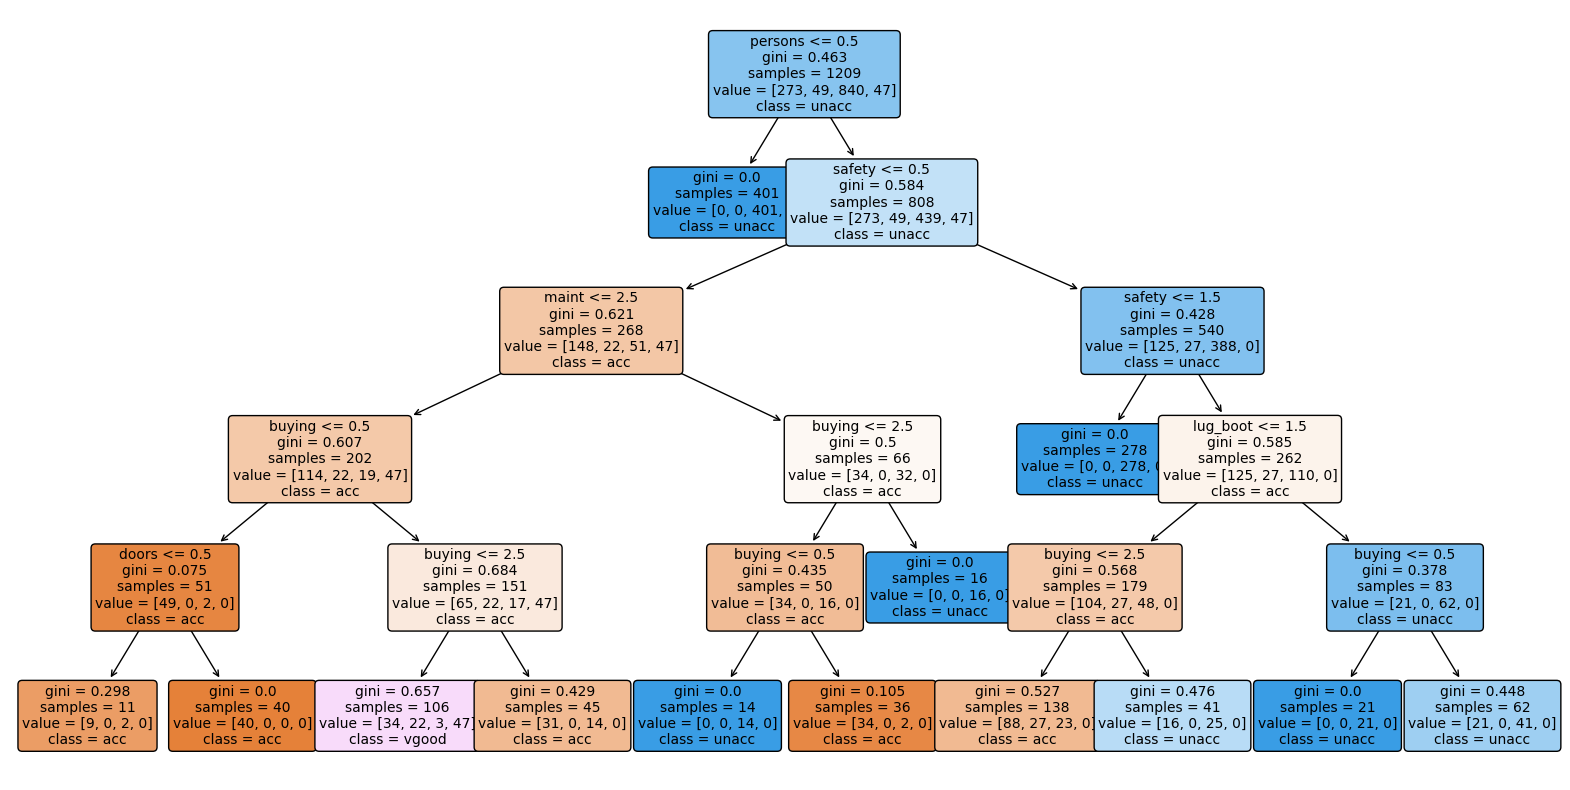

In [17]:
import metricas as mt
mt.tree_division(tree_model, x_test.columns)

In [18]:
#Calculo de las predicciones en Train y Test
from sklearn.metrics import accuracy_score

y_pred_test = tree_model.predict(x_test)

accuracy_score(y_test, y_pred_test)

0.8458574181117534

## Evaluación de modelo de clasificación con árbol de decisión

## Features importantes

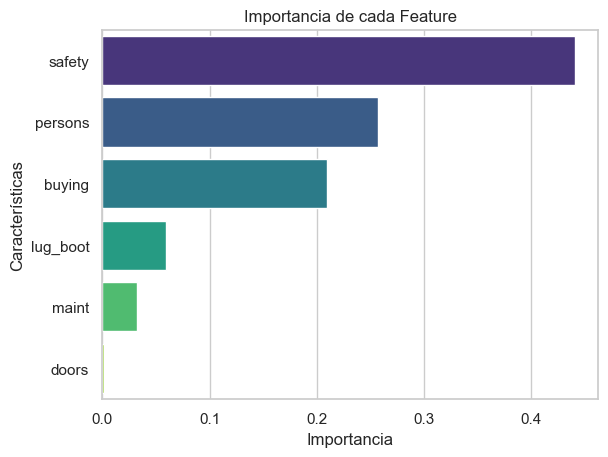

In [19]:
#Verificamos el feature importances

import seaborn as sns
import matplotlib.pyplot as plt

# Obtenemos las importancias de las características
importances = pd.Series(tree_model.feature_importances_, index=X.columns.values).sort_values(ascending=False)

# Configuramos la paleta de colores y la saturación
sns.set(style="whitegrid")  # Configuración del estilo
palette = sns.color_palette("viridis", len(importances))  # Paleta de colores personalizada

# Creación del gráfico de barras
sns.barplot(x=importances, y=importances.index, palette=palette, hue=importances.index, saturation=0.9, legend=False)

# Añadimos título y etiquetas
plt.title('Importancia de cada Feature')
plt.xlabel('Importancia')
plt.ylabel('Características')

# Mostramos el gráfico
plt.show()

## Evaluacion con datos de test

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Predicciones en los datos de prueba
y_pred = tree_model.predict(x_test)

# 1. Exactitud (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f'Exactitud: {accuracy:.2f}')

# 2. Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

# 3. Reporte de clasificación (Precisión, Recall, F1-Score)
report = classification_report(y_test, y_pred)
print('Reporte de clasificación:')
print(report)

from sklearn.metrics import roc_auc_score


# Si tu modelo es multiclase, usa la estrategia one-vs-rest
y_pred_proba = tree_model.predict_proba(x_test)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovo", average="macro")   # Revisar los parametors 'multi_class' y 'average'
print(f'ROC-AUC (macro): {roc_auc:.2f}')




Exactitud: 0.85
Matriz de confusión:
[[ 78   0  24   9]
 [ 12   0   0   8]
 [ 24   0 343   3]
 [  0   0   0  18]]
Reporte de clasificación:
              precision    recall  f1-score   support

         acc       0.68      0.70      0.69       111
        good       0.00      0.00      0.00        20
       unacc       0.93      0.93      0.93       370
       vgood       0.47      1.00      0.64        18

    accuracy                           0.85       519
   macro avg       0.52      0.66      0.57       519
weighted avg       0.83      0.85      0.83       519

ROC-AUC (macro): 0.86


c:\Users\Ares\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Ares\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Ares\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Entrenamiento de modelo de clasificación con random forest

In [21]:
#Importar random forest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df_diabetes = pd.read_csv('diabetes.csv')
df_diabetes.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


Descripción de cada variable con su traducción al español entre paréntesis:

1. **Pregnancies** (Embarazos): 
   - Número de embarazos que ha tenido la paciente.
   
2. **Glucose** (Glucosa): 
   - Concentración de glucosa en plasma después de una prueba de tolerancia a la glucosa.

3. **BloodPressure** (Presión Arterial): 
   - Presión arterial diastólica (mm Hg).

4. **SkinThickness** (Espesor de la Piel): 
   - Espesor del pliegue cutáneo del tríceps en milímetros.

5. **Insulin** (Insulina): 
   - Nivel de insulina en suero (mu U/ml).

6. **BMI** (Índice de Masa Corporal - IMC): 
   - Relación peso-talla, calculada como peso en kg dividido por el cuadrado de la altura en metros.

7. **DiabetesPedigreeFunction** (Función de Antecedentes Familiares de Diabetes): 
   - Puntaje que estima la probabilidad de que la paciente tenga diabetes en función de sus antecedentes familiares.

8. **Age** (Edad): 
   - Edad de la paciente en años.

9. **Outcome** (Resultado): 
   - Variable objetivo, donde 0 indica que la paciente no tiene diabetes y 1 indica que sí la tiene.



In [23]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Nuestros datos son continuos

In [24]:
# Separamos la data
X = df_diabetes.drop(['Outcome'], axis=1)
y = df_diabetes['Outcome']

In [25]:
#Calculo de las predicciones en Train y test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 69)

In [35]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Creacion del modelo
random_forest = RandomForestClassifier(n_estimators= 15, random_state = 69, oob_score= True)
random_forest

RandomForestClassifier(n_estimators=15, oob_score=True, random_state=69)

In [36]:
# Entrenamiento del modelo
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=15, oob_score=True, random_state=69)

In [37]:
# Predicciones de testeo y entrenamiento
y_pred_train = random_forest.predict(x_train)
y_pred_test = random_forest.predict(x_test)


## Evaluación de modelo de clasificación con random forest

In [38]:
#Calculo de metricas 
from sklearn.metrics import accuracy_score

#Calculo el accuracy en Train y tet
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

train_accuracy, test_accuracy

#Importante: podriamos reducir el numero de estimadores para disminuir el sobreajuste del modelo.

(0.9925512104283054, 0.7186147186147186)

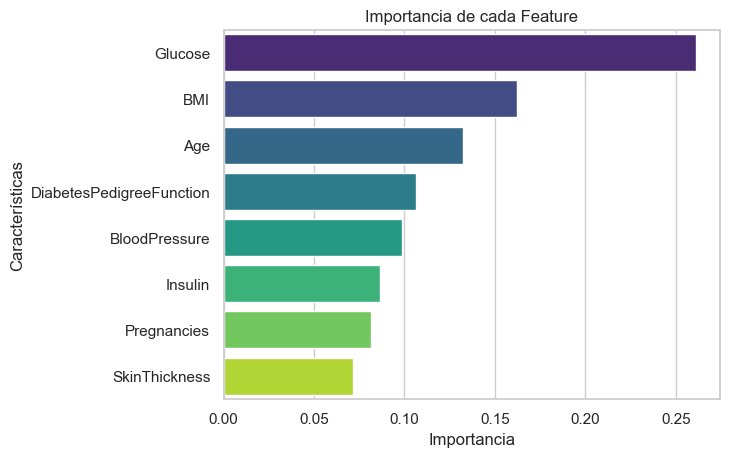

In [39]:
# Visualizacion de las feature importantes

importances = pd.Series(random_forest.feature_importances_, index=X.columns).sort_values(ascending=False)

# Configuramos la paleta de colores y la saturación
sns.set(style="whitegrid")  # Configuración del estilo
palette = sns.color_palette("viridis", len(importances))  # Paleta de colores personalizada

# Creación del gráfico de barras
sns.barplot(x=importances, y=importances.index, palette=palette, hue=importances.index, saturation=0.9, legend=False)

# Añadimos título y etiquetas
plt.title('Importancia de cada Feature')
plt.xlabel('Importancia')
plt.ylabel('Características')

# Mostramos el gráfico
plt.show()

In [31]:
# Matriz de confusion del RF
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_test)

array([[130,  18],
       [ 45,  38]], dtype=int64)

In [40]:

# Obtener el OOB score
oob_score = random_forest.oob_score_
print(f"Precisión OOB: {oob_score:.4f}")

# Calcular el Error OOB
oob_error = 1 - oob_score
print(f"Error OOB: {oob_error:.4f}")

Precisión OOB: 0.7169
Error OOB: 0.2831
